# Decision Tree

### Training model on complete dataset, i.e., without removing collinear features.

In [1]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment= None

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
#Providing dataset filepath

root='datasets/'

In [3]:
#Reading the final dataset pickle file into a dataframe.

dataframe = pd.read_pickle (root +'final_feature_data.pkl')
dataframe.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [4]:
# Function to reduce memory of the data frame
def reduce_mem(df):
    
    st_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of the dataframe is :",st_mem_usg,"MB")
    
    for column in df.columns:
        if df[column].dtypes in ["int64", "int32", "int16"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.iinfo(np.int8).min and colMax < np.iinfo(np.int8).max:
                df[column] = df[column].astype(np.int8)
            
            elif colMin > np.iinfo(np.int16).min and colMax < np.iinfo(np.int16).max:
                df[column] = df[column].astype(np.int16)
            
            elif colMin > np.iinfo(np.int32).min and colMax < np.iinfo(np.int32).max:
                df[column] = df[column].astype(np.int32)
        
        if df[column].dtypes in ["float64", "float32"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.finfo(np.float16).min and colMax < np.finfo(np.float16).max:
                df[column] = df[column].astype(np.float16)
            
            elif colMin > np.finfo(np.float32).min and colMax < np.finfo(np.float32).max:
                df[column] = df[column].astype(np.float32)
    
    print("Memory usage total")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage: ",mem_usg," MB")
    print("Size reduced by ",100*mem_usg/st_mem_usg,"%")
    
    return df

In [5]:
#Reducing dataframe memory consumption for storage management.

dataframe = reduce_mem(dataframe)

Memory usage of properties dataframe is : 4380.480062484741  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1309.2947788238525  MB
This is  29.88929889298893 % of the initial size


In [6]:
dataframe['order_diff'] = dataframe.order_number - dataframe.product_last_bought_order

In [7]:
dataframe.drop (['user_id', 'product_id'], axis= 1, inplace = True)

In [8]:
dataframe

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [9]:
#Taking a subset from complete dataset to train the model in stipulated time (complete dataset can be taken if we have more computation power).

dataframe= dataframe.sample(frac=.25)
dataframe

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
2153464,5.0,4.0,0.799805,4.601562,3.800781,37.0,0.0,0.0,0.0,43.0,...,0.708008,14.093750,0.680176,7,6,9,1.000000,0.833496,0.888672,6.0
1250639,1.0,0.0,0.000000,16.000000,15.000000,12.0,0.0,0.0,0.0,17.0,...,0.645508,13.750000,0.663086,17,13,12,0.823730,0.922852,0.666504,5.0
7649416,3.0,2.0,0.666504,8.664062,10.664062,33.0,0.0,0.0,0.0,45.0,...,0.448730,11.953125,0.444580,7,6,17,0.571289,0.500000,0.529297,12.0
8095756,1.0,0.0,0.000000,11.000000,0.000000,1.0,0.0,0.0,0.0,6.0,...,0.545410,17.593750,0.606934,23,11,11,1.000000,0.818359,1.000000,5.0
6794807,4.0,3.0,0.750000,4.000000,9.000000,10.0,1.0,1.0,0.0,11.0,...,0.531250,9.601562,0.511719,7,9,16,0.856934,0.555664,0.625000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7317216,3.0,2.0,0.666504,11.000000,6.667969,40.0,0.0,0.0,0.0,46.0,...,0.707031,15.625000,0.713867,7,14,26,0.856934,0.714355,0.769043,6.0
7399179,10.0,9.0,0.899902,7.500000,4.500000,72.0,0.0,0.0,0.0,77.0,...,0.778320,10.617188,0.804199,8,29,12,0.625000,0.655273,0.833496,5.0
2237326,6.0,5.0,0.833496,7.832031,0.833496,92.0,0.0,0.0,0.0,100.0,...,0.853516,19.593750,0.852051,21,25,19,0.952148,1.000000,0.947266,8.0
6507729,1.0,0.0,0.000000,5.000000,4.000000,39.0,0.0,0.0,0.0,50.0,...,0.759766,14.101562,0.739746,11,17,19,0.727051,0.941406,0.947266,11.0


In [10]:
label = 'reordered'
x_cols = dataframe.columns.drop('reordered')

In [11]:
X = dataframe[x_cols]
y = dataframe[label]

In [12]:
#Splitting the dataset into training and testing data.
#Stratify parameter is used to make a split so that ratio of values in the sample produced will be same/
#as the ratio of values given to it.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1588998, 67) (1588998,)
(529667, 67) (529667,)


In [13]:
#Determining parameter grid for estimator.

params_tree={
    'class_weight': [{0: 1, 1: 10}],
    'max_depth': [3, 4, 5, 10, 15],
    'max_features': ['auto'],
    'min_samples_split': [2, 3, 4, 5]
}

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
#Using GridSearchCV to cross-validate and perform hyper-parameter tuning.

treePrePruning=DecisionTreeClassifier()
cvprune=GridSearchCV (treePrePruning, params_tree, cv=3, scoring='accuracy')

In [16]:
#Training the model.

cvprune.fit (X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 10}],
                         'max_depth': [3, 4, 5, 10, 15],
                         'max_features': ['auto'],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='accuracy')

In [17]:
cvprune.best_params_

{'class_weight': {0: 1, 1: 10},
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 4}

In [18]:
y_pred_dt=cvprune.predict(X_test)

In [19]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions_dt = [1 if i > 0.5 else 0 for i in y_pred_dt]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.95      0.74      0.83    477699
         1.0       0.21      0.62      0.31     51968

    accuracy                           0.73    529667
   macro avg       0.58      0.68      0.57    529667
weighted avg       0.87      0.73      0.78    529667

Accuracy   Score :  0.7303664377807189
F1 Score:  0.309947623741327


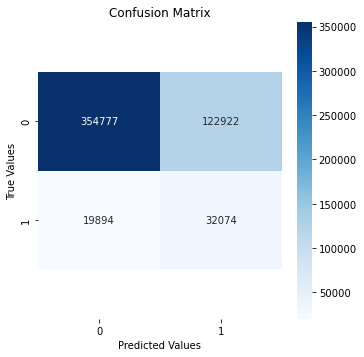

In [20]:
print ("\n Classification report : \n",classification_report (y_test, predictions_dt))
print ("Accuracy   Score : ",accuracy_score (y_test, predictions_dt))

#Generate confusion-matrix as below
conf_matrix_dt= confusion_matrix (y_test,predictions_dt)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix_dt, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.xlabel ('Predicted Values')
plt.title ('Confusion Matrix')
plt.ylabel ('True Values')

#Generate F1-score as below
f1 = f1_score (y_test, predictions_dt)
print ("F1 Score: ", f1)

### Training model on updated dataset, i.e., by removing collinear features.

In [21]:
#Reading the updated dataset pickle file with collinear features removed, into a dataframe.

df_non_collinear = pd.read_pickle(root + 'corr_removed_feature_data.pkl')
df_non_collinear.head()

,user_id,product_id,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,...,std_since_order,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667


In [22]:
#Reducing dataframe memory consumption for storage management.

df_non_collinear = reduce_mem(df_non_collinear)

Memory usage of properties dataframe is : 3281.319013595581  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  913.2735185623169  MB
This is  27.832512315270936 % of the initial size


In [23]:
df_non_collinear['order_diff'] = df_non_collinear.order_number - df_non_collinear.product_last_bought_order

In [24]:
df_non_collinear.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [25]:
df_non_collinear

,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,...,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,7.0


In [26]:
#Taking a subset from complete dataset to train the model in stipulated time (complete dataset can be taken if we have more computation power).

df_non_collinear=df_non_collinear.sample(frac=.25)
df_non_collinear

,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,...,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
6195494,1.0,0.000000,11.000000,13.000000,12.0,0.0,0.0,0.0,18.0,5.0,...,111,0.396484,6.531250,7,5,8,0.142822,0.399902,0.750000,6.0
7509111,1.0,0.000000,4.000000,2.000000,37.0,0.0,0.0,0.0,100.0,3.0,...,755,0.611816,7.625000,20,8,6,0.649902,0.625000,0.666504,63.0
398070,2.0,0.500000,13.500000,6.000000,14.0,1.0,0.0,0.0,15.0,3.0,...,193,0.466309,13.789062,6,12,16,0.333252,0.833496,0.562500,1.0
522076,3.0,0.666504,7.667969,14.335938,24.0,1.0,0.0,0.0,27.0,6.0,...,353,0.600586,13.578125,19,15,9,0.473633,0.533203,0.777832,3.0
1219873,1.0,0.000000,2.000000,11.000000,37.0,0.0,0.0,0.0,46.0,5.0,...,693,0.596191,15.398438,6,29,9,0.833496,0.862305,0.666504,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609749,1.0,0.000000,21.000000,13.000000,5.0,0.0,0.0,0.0,9.0,2.0,...,123,0.325195,15.375000,17,37,10,0.411865,0.324219,0.899902,4.0
2555886,1.0,0.000000,4.000000,17.000000,6.0,0.0,0.0,0.0,25.0,5.0,...,276,0.445557,11.500000,8,3,6,0.875000,1.000000,1.000000,19.0
5096773,26.0,0.961426,11.617188,8.265625,53.0,1.0,0.0,0.0,55.0,4.0,...,983,0.815918,18.203125,21,30,20,0.761719,0.633301,0.950195,2.0
5870799,2.0,0.500000,10.500000,14.500000,12.0,0.0,0.0,0.0,28.0,3.0,...,217,0.460938,8.039062,21,9,6,0.476074,0.555664,0.333252,16.0


In [27]:
label_non_collinear = 'reordered'
x_cols_non_collinear = df_non_collinear.columns.drop('reordered')

In [28]:
X = df_non_collinear[x_cols_non_collinear]
y = df_non_collinear[label_non_collinear]

In [29]:
#Splitting the dataset into training and testing data.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1588998, 50) (1588998,)
(529667, 50) (529667,)


In [30]:
#Using GridSearchCV to cross-validate and perform hyper-parameter tuning.

treePrePruning_non_collinear=DecisionTreeClassifier()
cvprune_non_collinear=GridSearchCV(treePrePruning_non_collinear, params_tree, cv=3, scoring='accuracy')

In [31]:
#Training the model.

cvprune_non_collinear.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 10}],
                         'max_depth': [3, 4, 5, 10, 15],
                         'max_features': ['auto'],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='accuracy')

In [32]:
y_pred_dt=cvprune_non_collinear.predict(X_test)

In [33]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions_dt = [1 if i > 0.5 else 0 for i in y_pred_dt]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.95      0.80      0.87    477841
         1.0       0.24      0.58      0.34     51826

    accuracy                           0.78    529667
   macro avg       0.59      0.69      0.60    529667
weighted avg       0.88      0.78      0.81    529667

Accuracy   Score :  0.7769372077173016
F1 Score:  0.3384158803930901


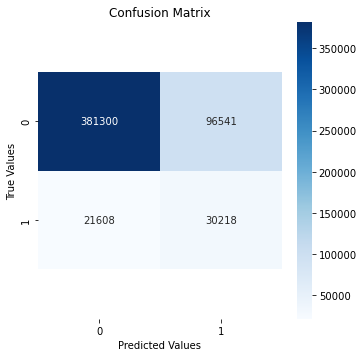

In [34]:
print ("\n Classification report : \n",classification_report (y_test, predictions_dt))
print ("Accuracy   Score : ",accuracy_score (y_test, predictions_dt))

#Generate confusion-matrix as below
conf_matrix_dt= confusion_matrix (y_test,predictions_dt)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix_dt, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.xlabel ('Predicted Values')
plt.title ('Confusion Matrix')
plt.ylabel ('True Values')

#Generate F1-score as below
f1 = f1_score (y_test, predictions_dt)
print ("F1 Score: ", f1)